## Install the package dependencies before running this notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lstm_encoder_decoder_no_early

In [13]:
import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pickle

import numpy as np
import pandas as pd
import random
import math

import gc
import os, os.path 
import pickle
from glob import glob
import matplotlib.pyplot as plt
import time

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- val: 55029 test:7971
    # pittsburgh -- val: 43544 test: 6361
    # dearborn -- val: 24465 test: 3671
    # washington-dc -- val: 25744 test: 3829
    # palo-alto -- val:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- val: 55029 test:7971\n    # pittsburgh -- val: 43544 test: 6361\n    # dearborn -- val: 24465 test: 3671\n    # washington-dc -- val: 25744 test: 3829\n    # palo-alto -- val:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [4]:
ROOT_PATH = "../../argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test", "val"] 

def get_city_trajectories(city="palo-alto", split="train", SEED=42):

    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)

        np.random.seed(SEED)
        shuffler = np.random.permutation(n)
        
        inputs = np.asarray(inputs)
        inputs = inputs[shuffler]
        inputs = inputs[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        outputs = outputs[shuffler]
        outputs = outputs[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)

        np.random.seed(SEED)
        shuffler = np.random.permutation(n)
        
        inputs = np.asarray(inputs)
        inputs = inputs[shuffler]
        inputs = inputs[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        outputs = outputs[shuffler]
        outputs = outputs[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
        outputs = torch.zeros(n,60, 2).to(device)

    return inputs, outputs


class ArgoverseDataset(Dataset):
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.split = split
        self.input_positions, self.output_positions = get_city_trajectories(city=city, split=split)
        
        self.input_positions = torch.Tensor(self.input_positions)
        num_inputs, input_seq_len = self.input_positions.shape[:2]
        self.center_input = (
            np.repeat(self.input_positions[:, 0, :], input_seq_len, axis=0)
            .reshape(num_inputs, input_seq_len, 2)
        )
        self.center = (
            np.repeat(self.input_positions[:, 0, :], 60, axis=0)
            .reshape(num_inputs, 120)
        )
        
        self.input_positions_centered = torch.Tensor(self.input_positions - self.center_input)
        self.input_velocities = torch.Tensor(np.diff(self.input_positions, axis=1))
        
        self.nn_pos_inputs = self.input_positions_centered
        self.nn_velo_inputs = self.input_velocities
        
        if split != 'test': 
            self.output_positions = torch.Tensor(self.output_positions)
            num_outputs, output_seq_len = self.output_positions.shape[:2]
            center_output = (
                np.repeat(self.input_positions[:, 0, :], output_seq_len, axis=0)
                .reshape(num_outputs, output_seq_len, 2)
            )
            self.output_positions_centered = torch.Tensor(self.output_positions - center_output)
            self.output_velocities = torch.Tensor(np.diff(self.output_positions, axis=1))
                    
            self.nn_pos_outputs = self.output_positions_centered[:, 0, :].unsqueeze(1)
            self.nn_velo_outputs = self.output_velocities

    def __len__(self):
        return len(self.nn_pos_inputs)

    def __getitem__(self, idx):
        if self.split != 'test':
            data = (
                self.nn_pos_inputs[idx], 
                self.nn_pos_outputs[idx], 
                self.nn_velo_inputs[idx], 
                self.nn_velo_outputs[idx],
                self.input_positions[idx],
                self.output_positions[idx],
                self.input_positions_centered[idx],
                self.output_positions_centered[idx]
            )
        else:
            data = data = (
                self.nn_pos_inputs[idx], 
                self.nn_velo_inputs[idx], 
                self.center[idx]
            )
        return data

In [5]:
!nvidia-smi

Sat May 28 22:02:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P5    40W / 370W |   3155MiB / 12288MiB |     33%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# function that tells how long training takes
def train_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs 

### Random shuffle with seed 42 & add attention

Training austin


 37%|███▋      | 22/60 [00:36<01:03,  1.67s/it, loss=0.18941] 

Epoch 00022: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 60/60 [01:40<00:00,  1.67s/it, loss=0.00231]

Epoch 00060: reducing learning rate of group 0 to 1.0000e-05.


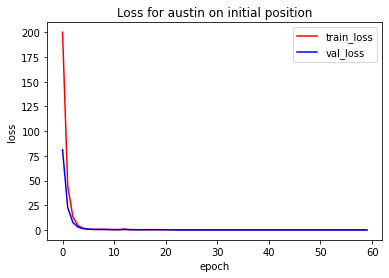

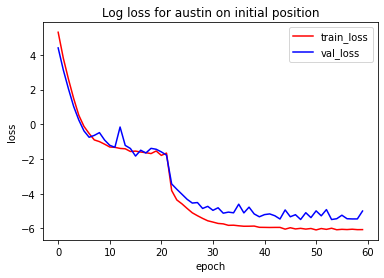

  2%|▏         | 2/120 [00:42<41:31, 21.11s/it, loss=0.00653]

In [19]:
%%time

# train one model for each city
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for city in cities:
    print('Training ' + str(city))
    train_dataset = ArgoverseDataset(city, 'train')
    val_dataset = ArgoverseDataset(city, 'val')


    X_train_nn_pos = train_dataset.nn_pos_inputs.to(device)
    y_train_nn_pos = train_dataset.nn_pos_outputs.to(device)
    X_train_nn_velo = train_dataset.nn_velo_inputs.to(device)
    y_train_nn_velo = train_dataset.nn_velo_outputs.to(device)
    X_train = train_dataset.input_positions.to(device)
    y_train = train_dataset.output_positions.to(device)
    
    X_val_nn_pos = val_dataset.nn_pos_inputs.to(device)
    y_val_nn_pos = val_dataset.nn_pos_outputs.to(device)
    X_val_nn_velo = val_dataset.nn_velo_inputs.to(device)
    y_val_nn_velo = val_dataset.nn_velo_outputs.to(device)
    X_val = val_dataset.input_positions.to(device)
    y_val = val_dataset.output_positions.to(device)

    start_time = time.time()
    nn_pos = lstm_encoder_decoder_no_early.lstm_seq2seq(
        input_size=2,
        input_len=50,
        output_size=2,
        hidden_size=128,
        num_layers=1,
        dropout=0.
    )

    nn_pos.to(device)

    train_losses_pos, val_losses_pos = lstm_encoder_decoder_no_early.train_model(
        nn_pos,
        city,
        X_train_nn_pos,
        y_train_nn_pos,
        X_train_nn_pos,
        y_train_nn_pos,
        n_epochs=60,
        target_len=1,
        batch_size=128,
        patience = 5,
        threshold = 1e-3,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.001,
        dynamic_tf=False,
        early_stop_criteria = 6,
        device=device,
        model_type='pos'
    )


    plt.title("Loss for " + city + " on initial position")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_pos, color="red", label="train_loss")
    plt.plot(val_losses_pos, color="blue", label="val_loss")
    plt.legend()
    plt.show()

    plt.title("Log loss for " + city + " on initial position")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(np.log(train_losses_pos), color="red", label="train_loss")
    plt.plot(np.log(val_losses_pos), color="blue", label="val_loss")
    plt.legend()
    plt.show()


    nn_velo = lstm_encoder_decoder_no_early.lstm_seq2seq(
        input_size=2,
        input_len=49,
        output_size=2,
        hidden_size=512,
        num_layers=1,
        dropout=0.
    )

    nn_velo.to(device)

    train_losses_velo, val_losses_velo = lstm_encoder_decoder_no_early.train_model(
        nn_velo,
        city,
        X_train_nn_velo,
        y_train_nn_velo,
        X_val_nn_velo,
        y_val_nn_velo,
        n_epochs=120,
        target_len=59,
        batch_size=128,
        patience = 10,
        threshold = 1e-4,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.0001,
        dynamic_tf=False,
        early_stop_criteria = 12,
        device=device,
        model_type='velo'
    )

    plt.title("Loss for " + city + " on velocity")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_velo, color="red", label="train_loss")
    plt.plot(val_losses_velo, color="blue", label="val_loss")
    plt.legend()
    plt.show()

    plt.title("Log loss for " + city + " on velocity")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(np.log(train_losses_velo), color="red", label="train_loss")
    plt.plot(np.log(val_losses_velo), color="blue", label="val_loss")
    plt.legend()
    plt.show()

    end_time = time.time()
    train_mins, train_secs = train_time(start_time, end_time)
    print(
        f'Total training time is: {train_mins}m {train_secs}s' + ' for ' + city)

### Generate CSV

In [ ]:
nn_pos.eval()
nn_velo.eval()
num_layers_pos = 1
num_layers_velo = 1

all_preds = []
for city in cities:
    test_dataset = ArgoverseDataset(city=city, split='test')
    rows = []
    model_pos = pickle.load(open('../models/seq2seq_lstm_pos_atten_' + str(num_layers_pos) + '_' + city, 'rb'))
    model_velo = pickle.load(open('../models/seq2seq_lstm_velo_atten_' + str(num_layers_velo) + '_' + city, 'rb'))
    for n in range(test_dataset.__len__()):
        if n % 1_000 == 0 and n > 0: 
            print(str(n) + ' predictions for ' + str(city) + ' completed.')
        nn_pos_nth_input, nn_velo_nth_input, center_input = test_dataset.__getitem__(n)
        nn_pos_nth_input = nn_pos_nth_input.to(device)
        nn_velo_nth_input = nn_velo_nth_input.to(device)
        center_input = center_input.to(device)
        init_pos = lstm_encoder_decoder_no_early.predict(model_pos, nn_pos_nth_input, 1, device=device)
        deltas = lstm_encoder_decoder_no_early.predict(model_velo, nn_velo_nth_input, 59, device=device)

        pred = (torch.cumsum(torch.cat((init_pos, deltas)), dim=0).flatten() + center_input).cpu().numpy()
        rows.append(pred)
    ids = np.array([str(i) + '_' + city for i in range(len(rows))])
    cols = np.array(['v' + str(i) for i in range(120)])
    predictions = pd.DataFrame(rows, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
all_predictions = pd.concat(all_preds, ignore_index=True)

In [ ]:
all_predictions.to_csv('two_lstm_enc_dec_out_5.csv', index=False)